Timothy Yi,  Chetana Iyer, Tommy Le

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import wavfile
from scipy import signal
from tqdm.notebook import tqdm
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import librosa
import librosa.display
import sounddevice as sd

### Load the meta files for train and test dataset

The meta data can be loaded as ``pandas.DataFrame`` in Python, where each row coresponds to one cough recording. Each recording has a variaty of attributes or 'features' associated with it. The feature that is the most important for our purpose is ``gender`` and has the two possible values 'male' and 'female'. (Unfortunately, the dataset does not have enough samples to include non-binary genders).

In [2]:
# load train and test meta data
train_path = 'train.csv'
train_df = pd.read_csv(train_path)
test_path = 'test.csv'
test_df = pd.read_csv(test_path)

# display train dataset - first 10 samples of the table
train_df.head(10)
print(f"Number of samples: {train_df.shape[0]}")
print(f"Number of labels for each sample: {train_df.shape[1]}")

Number of samples: 5584
Number of labels for each sample: 53


### Load the train and test dataset

#### Assignment 1:

1.  Use the function ``load_dataset()`` (with parameters ``transform = 'none'`` and ``downsample = True``) to load train and test dataset. The code for loading the train dataset is already provided in the starter code. You still have to write the code line for loading the test dataset (this is an easy task). ``load_dataset()`` returns a tuple ``(data, labels)``, where ``data`` contains the audio time series organized in a 2D numpy array and ``labels`` contains the labels (*male* or *female*) for each audio sample. *male* and *female* are encoded as 0 and 1, respectively. Each row of ``data`` is a single cough recording and the corresponding row in ``labels`` is its corresponding label. That is, the audio time series and label of the $i^\mathrm{th}$ recording can be accessed by ``audio = data[i]`` and ``label = labels[i]``. If ``downsample $=$ True``, the cough recordings are downsampled to a sampling frequency of \11025 Hz.
2. Plot the time series of a single recording using ``plt.plot()`` and play the cough using the ``sounddevice.play()`` function from Lab 2. You can display any recording you like. The x-axis of your plot should be in seconds. Make sure to label both x- and y-axis properly. Print the label of the corresponding recording.

In [3]:
def load_dataset(path_dataset, path_meta, transform='none', downsample=True):
    """
    path_dataset : str
        path of the folder that contains the audio samples
    path_meta : str
        path of the metadata file corresponding to the dataset
    transform : str
        'none' for no transform of the data or 'spec' for transforming the data into spectrograms
    downsample : bool
        If True, the audio recording will be downsampled to a frequency of 11025 Hz.
    """
    dataset_meta = pd.read_csv(path_meta)
        
    labels = dataset_meta['gender'].copy()
    labels.iloc[(dataset_meta['gender'] == 'male').values] = 0
    labels.iloc[(dataset_meta['gender'] == 'female').values] = 1

    audio = []
    for uuid in tqdm(dataset_meta.uuid):
        fs, audio_single = wavfile.read(path_dataset + uuid + '.wav')
        audio_single =  signal.resample_poly(audio_single, 1, 2)
        if transform == 'spec':
            f, t, audio_single = spec(audio_single, N=512) #if you cannot finish assignment 3, replace spec by spec2
        
        audio.append(audio_single / np.max(abs(audio_single)))
        
    audio = np.array(audio)
    if transform == 'spec':
        dim1 = audio.shape[0]
        dim2 = audio.shape[1]
        dim3 = audio.shape[2]
        
        audio = audio.reshape(dim1, dim2, dim3, 1)

    labels = labels.values.astype('uint8').reshape(-1,1)
    return audio, labels

In [4]:
# load datasets
data_train, labels_train = load_dataset('train/', 'train.csv', transform=None)
# TODO: load test set
data_test, labels_test = load_dataset('test/', 'test.csv', transform=None)

  0%|          | 0/5584 [00:00<?, ?it/s]

  0%|          | 0/1396 [00:00<?, ?it/s]

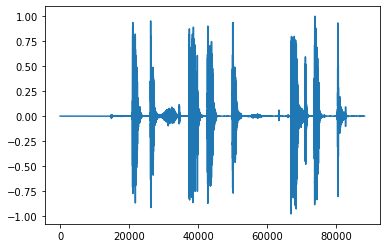

In [5]:
# TODO: plot time series of single recording
fig1 = plt.figure(1)
plt.plot(data_train[6]) # plot time series of 1st recording 
sd.play(data_train[6], samplerate = 11025) # play the cough

## A Naive Deep learning Implementation

#### Assigment 2a:
Add at least to additional ``Dense`` layers to the network architecture in the starter code.
You are free to chose the number of neurons, and activation function in each layer.

In [6]:
# model for raw time series data
model = models.Sequential() # groups a linear stack of layers into a tensorflow.keras.Model, basically this builds your model framework
model.add(layers.Input(data_train.shape[1]))
model.add(layers.Dense(100, activation = 'sigmoid'))

# TODO: add at least 2 more layers to the network
model.add(layers.Dense(150, activation = 'sigmoid'))
model.add(layers.Dense(200, activation = 'sigmoid'))

model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss = 'binary_crossentropy', metrics= ['accuracy'])
history = model.fit(data_train, labels_train, epochs = 10, validation_data = (data_test,
                    labels_test), batch_size = 128, shuffle = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               8820100   
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 200)               30200     
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 8,865,651
Trainable params: 8,865,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
44/44 [==============================] - 4s 77ms/step - loss: 0.6975 - accuracy: 0.4977 - val_loss: 0.6933 - val_accuracy: 0.5136
Epoch 2/10
44/44 [===================

#### Assigment 2b:
Run the model fitting and describe (in words in a separate markdown cell), how the classification accuracy on the train and test set changes throughout the model training.
Plot train and test set accuracy as a function of epoch number and report the final accuracy on the test set. (The code for that is already provided and all you have to do is execute it.)
Assume, you have a new cough sound sample that the model has not seen before.
How likely do you think is it that the model detects the right gender.
Comment on that in the notebook.

Discussion:
Throughout the model training, the accuracy on the train set greatly increase from epoch #0 to #4 and then flattens at 1 for the remaining epochs. As for the test set, the accuracy is generally 0.5 for the entirety of the training. Assuming we used a new cough sample, the model would not likely be able to detect the right gender.

44/44 - 0s - loss: 2.9302 - accuracy: 0.4950 - 500ms/epoch - 11ms/step
test accuracy is :  0.4949856698513031


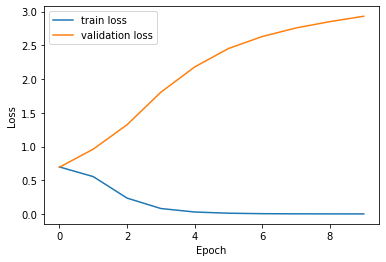

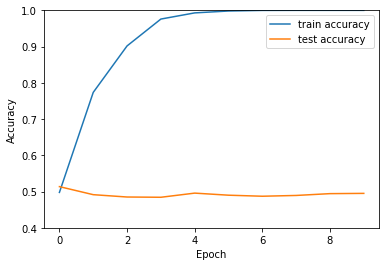

In [7]:
# plot the loss of train and test set throughout the training procedure
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot the accuracy of train and test set throughout the training procedure
plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.4, 1])

# compute final accuracy on test set
test_loss, test_acc = model.evaluate(data_test, labels_test, verbose=2)
print('test accuracy is : ', test_acc)

## Representing Audio Signals as Spectrograms

#### Assignment 3:

1.  Complete the function ``spec()`` that computes the spectrogram of a single audio signal. The function takes as inputs the audio signal ``x`` and the window length of the STFT ``N``. Assume a window hop size of $T = N$. That is, adjacent segments do not overlap. For the window function we use a simple rectangular window. Your implementation should include the following steps:
    * split the signal $x$ into $K$ segments of length $N$.
	* compute the FFT of each segment and only store the frequency points from $k=0$ to $N/2$ (corresponding to the DTFT frequency from 0 to $\pi$.).
	* Compute the magnitude square according to Eq. 3 in the lab instructions.
	* Compute the normalized spectrogram
		$$\tilde{S}[m,k] = \frac{S[m,k]}{\mathrm{max}\left(S[m,k]\right)}$$.

2. Once you have completed your implementation of ``spec()``, run the code cell that computes the spectrogram of a single cough sound and compare it with numpy's spectrogram function used in ``spec2()``. The two spectrograms you get should look identical.

In [8]:
def spec(x, N):
    """
    Computes the spectrogram of signal x.
    
    x : np.ndarray
        discrete time signal
    N : int
        length of each segment
        
    return (f, t, Sxx), where t is the array of time indies, f, the array of frequency indices, and
    Sxx a 2-dimensional array where each row corresponds to the DFT of a single segment.
    """
    
    # TODO: split signal into K segments of length N
    K = int(len(x)/N)
    x_K = np.split(x[:K * N], K)

    # TODO: compute their FFT and store frequency points between 0 to N/2 
    x_fft = np.fft.fft(x_K).T


    # TODO: Compute the spectrogram
    Sxx = np.abs(x_fft[:N//2]) ** 2

    # TODO: normalize the spectrogram
    Sxx /= np.max(abs(Sxx))

    # defines time and frequency array (you don't need to change anything here
    # if your implementation above is correct)
    t = np.arange(0, K, 1)
    f = np.linspace(0, 0.5, int(N/2 + 1))
    
    return f, t, Sxx

def spec2(x, N):
    f, t, Sxx = signal.spectrogram(x, nperseg=N, window='boxcar', noverlap=0)
    Sxx /= np.max(abs(Sxx))
    return f, t, Sxx

C:\Users\MASTER~1\AppData\Local\Temp/ipykernel_2160/2977555546.py:17: RuntimeWarning: divide by zero encountered in log10
  Sxx_log = 10*np.log10(Sxx)
C:\Users\MASTER~1\AppData\Local\Temp/ipykernel_2160/2977555546.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, Sxx_log, vmin=-50, cmap='jet')
C:\Users\MASTER~1\AppData\Local\Temp/ipykernel_2160/2977555546.py:28: RuntimeWarning: divide by zero encountered in log10
  Sxx2_log = 10*np.log10(Sxx2)
C:\Users\MASTER~1\AppData\Local\Temp/ipykernel_2160/2977555546.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shad

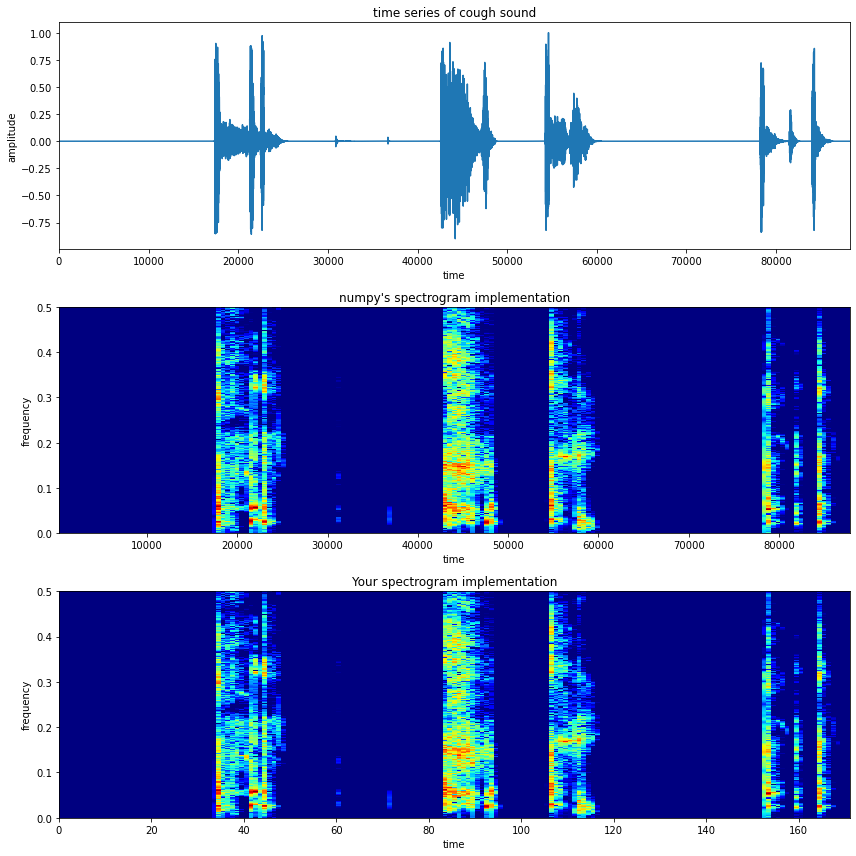

In [9]:
# test spec function on single cough sound. The output should be the same a spec2.
# All you need to to here is to run this cell.
audio_single = data_train[0]

# plot time series
fig, ax = plt.subplots(figsize=(12,12), nrows=3)
plt.subplot(311)
plt.plot(audio_single)
plt.xlim(0, len(audio_single) - 1)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('time series of cough sound')

# plot spectrogram using numpy's implementation
f, t, Sxx = spec2(audio_single, N=512)
plt.subplot(312)
Sxx_log = 10*np.log10(Sxx)
Sxx_log[Sxx_log == -np.inf] = -50
plt.pcolormesh(t, f, Sxx_log, vmin=-50, cmap='jet')
plt.xlabel('time')
plt.ylabel('frequency')
plt.title("numpy's spectrogram implementation")


# plot spectrogram using your implementation
f2, t2, Sxx2 = spec(audio_single, N=512)
plt.subplot(313)
Sxx2_log = 10*np.log10(Sxx2)
Sxx2_log[Sxx2_log == -np.inf] = -50
plt.pcolormesh(t2, f2, Sxx2_log, vmin=-50, cmap='jet')
plt.xlabel('time')
plt.ylabel('frequency')
plt.title("Your spectrogram implementation")
plt.tight_layout()
plt.show()

## Using Spectrograms and Convolutional Neural Networks to Classify Cough Sounds

#### Assignment 4:
1. Load the train and test set using the ``load\_dataset()`` function with the parameter ``transform='spec'`` (you only need to run the corresponding code cell in the starter code).
2. Build the CNN architecture. An initial architecture with one convolutional layer has already been provided in the starter code. Add at least one more convolutional layer followed by a MaxPooling layer to the architecture. The important input parameters of the \textcodefont{Conv2D} layer are
     * ``filters``: number of convolutional kernels
	 * ``kernel_size``: size of each kernel
	 * ``activation``: The activation function that is used for the output of the convolutional layer. You should use the ``'relu'`` function.

  The ``MaxPooling`` layer only takes a ``pool_size`` that is equivalent to the ``kernel_size`` of the convolutional layer.

3. Run the next code cell of the starter notebook to train your architecture. As in Assignment 2, the printout will tell you the accuracy of the classifier on the train and test set after each epoch.
4. As in Assignment 2, plot the accuracy on the train and test set as a function of epoch
5.  Change the parameters of your CNN architecture (number of layers, kernel size, etc.) to get as high of an accuracy on the test set as possible. Describe the observations you make (What changes seem to improve/decrease the test set accuracy? How does the accuracy on train and test set change throughout the training process (i.e., with increasing number of epochs)?). You should be able to get an accuracy of at least 71-72% on the test set.

In [10]:
# delete dense model and untransformed dataset to clear memory
del model, data_train, labels_train, data_test, labels_test

In [11]:
# load spectrogram transformed dataset
data_train_spec, labels_train = load_dataset('train/', 'train.csv', transform='spec')
data_test_spec, labels_test = load_dataset('test/', 'test.csv', transform='spec')

  0%|          | 0/5584 [00:00<?, ?it/s]

  0%|          | 0/1396 [00:00<?, ?it/s]

In [12]:
# CNN architecture
model = models.Sequential() # groups a linear stack of layers into a tensorflow.keras.Model, basically this builds your model framework

# this one is a conv2D+maxPooling
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=(2,2),
                        input_shape=data_train_spec.shape[1:]),)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#TODO: add at least two or more layers and chnage the parameters of the layers
# note that you do not need to pass the parameters 'input_shape' or 'strides', to the subsequent layers
model.add(layers.Conv2D(filters=92, kernel_size=(4, 4), activation='relu')) 
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=72, kernel_size=(2, 2), activation='relu')) 
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 84, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 42, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 39, 92)        47196     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 19, 92)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 18, 72)        26568     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 9, 72)       

In [13]:
# train the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(data_train_spec, labels_train, batch_size=128, epochs=20,
                    validation_data=(data_test_spec, labels_test), shuffle=True)

Epoch 1/20
44/44 [==============================] - 48s 1s/step - loss: 0.6854 - accuracy: 0.5484 - val_loss: 0.6595 - val_accuracy: 0.6454
Epoch 2/20
44/44 [==============================] - 46s 1s/step - loss: 0.6434 - accuracy: 0.6467 - val_loss: 0.6142 - val_accuracy: 0.6755
Epoch 3/20
44/44 [==============================] - 47s 1s/step - loss: 0.6177 - accuracy: 0.6746 - val_loss: 0.6062 - val_accuracy: 0.6769
Epoch 4/20
44/44 [==============================] - 46s 1s/step - loss: 0.5992 - accuracy: 0.6843 - val_loss: 0.5986 - val_accuracy: 0.6956
Epoch 5/20
44/44 [==============================] - 49s 1s/step - loss: 0.5827 - accuracy: 0.7004 - val_loss: 0.5931 - val_accuracy: 0.6905
Epoch 6/20
44/44 [==============================] - 48s 1s/step - loss: 0.5731 - accuracy: 0.7024 - val_loss: 0.5859 - val_accuracy: 0.7077
Epoch 7/20
44/44 [==============================] - 46s 1s/step - loss: 0.5610 - accuracy: 0.7113 - val_loss: 0.5737 - val_accuracy: 0.7034
Epoch 8/20
44/44 [==

44/44 - 3s - loss: 0.6056 - accuracy: 0.7342 - 3s/epoch - 72ms/step
test accuracy is :  0.734240710735321


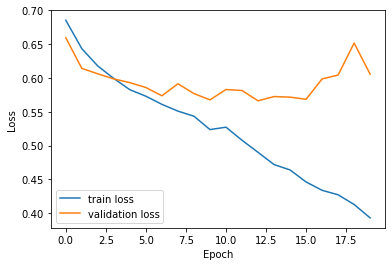

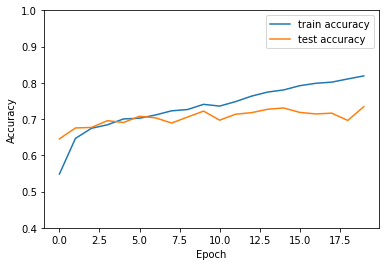

In [15]:
# TODO: plot the model performance as a function of epoch
# plot the loss of train and test set throughout the training procedure
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot the accuracy of train and test set throughout the training procedure
plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.4, 1])

# compute final accuracy on test set
test_loss, test_acc = model.evaluate(data_test_spec, labels_test, verbose=2)
print('test accuracy is : ', test_acc)

Discussion: Observations that seemed to have improved the test accuracy was increasing the number of filters and decreasing the kernel size for each convolution layer. As seen in the plot, the model seems to be overfitting around epoch #10. A possible solution to handle overfitting could be stopping the training early instead of going through all 20 epochs.The accuracy of the train set greatly increases on the first three epochs. As the number of epochs increase, the accuracy of the train set will gradually increase. The accuracy of the test set gradually increases until epoch # 7 - 8. After the 8th epoch, the accuracy will spike up and down, but in the general range of 0.69 to 0.72.